The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.14.4


# Bidirectional Recurrent Neural Networks
:label:`sec_bi_rnn`


So far we assumed that our goal is to model the next word given what we have seen so far, e.g., in the context of a time series or in the context of a language model. While this is a typical scenario, it is not the only one we might encounter. To illustrate the issue, consider the following three tasks of filling in the blanks in a text:

1. `I am _____`
2. `I am _____ very hungry.`
3. `I am _____ very hungry, I could eat half a pig.`

Depending on the amount of information available, we might fill the blanks with very different words such as "happy", "not", and "very". Clearly the end of the phrase (if available) conveys significant information about which word to pick. A sequence model that is incapable of taking advantage of this will perform poorly on related tasks. For instance, to do well in named entity recognition (e.g., to recognize whether "Green" refers to "Mr. Green" or to the color) longer-range context is equally vital. To get some inspiration for addressing the problem let us take a detour to graphical models.

## Dynamic Programming

This section serves to illustrate the dynamic programming problem. The specific technical details do not matter for understanding the deep learning counterpart but they help in motivating why one might use deep learning and why one might pick specific architectures.

If we want to solve the problem using graphical models we could for instance design a latent variable model as follows. We assume that there exists some latent variable $h_t$ which governs the emissions $x_t$ that we observe via $p(x_t \mid h_t)$. Moreover, the transitions $h_t \to h_{t+1}$ are given by some state transition probability $p(h_{t+1} \mid h_{t})$. The graphical model is then a Hidden Markov Model (HMM) as in :numref:`fig_hmm`.

![ Hidden Markov Model. ](http://d2l.ai/_images/hmm.svg)
:label:`fig_hmm`

Thus, for a sequence of $T$ observations we have the following joint probability distribution over observed and hidden states:

$$p(x, h) = p(h_1) p(x_1 \mid h_1) \prod_{t=2}^T p(h_t \mid h_{t-1}) p(x_t \mid h_t).$$

Now assume that we observe all $x_i$ with the exception of some $x_j$ and it is our goal to compute $p(x_j \mid x^{-j})$, where $x^{-j} = (x_1, x_2, \ldots, x_{j-1})$. To accomplish this we need to sum over all possible choices of $h = (h_1, \ldots, h_T)$. In case $h_i$ can take on $k$ distinct values, this means that we need to sum over $k^T$ terms---mission impossible! Fortunately there is an elegant solution for this: dynamic programming. To see how it works, consider summing over the first two hidden variable $h_1$ and $h_2$. This yields:

$$\begin{aligned}
    p(x) & = \sum_{h_1, \ldots, h_T} p(x_1, \ldots, x_T; h_1, \ldots, h_T) \\
    & = \sum_{h_1, \ldots, h_T} p(h_1) p(x_1 \mid h_1) \prod_{t=2}^T p(h_t \mid h_{t-1}) p(x_t \mid h_t) \\
    & = \sum_{h_2, \ldots, h_T} \underbrace{\left[\sum_{h_1} p(h_1) p(x_1 \mid h_1) p(h_2 \mid h_1)\right]}_{=: \pi_2(h_2)}
    p(x_2 \mid h_2) \prod_{t=3}^T p(h_t \mid h_{t-1}) p(x_t \mid h_t) \\
    & = \sum_{h_3, \ldots, h_T} \underbrace{\left[\sum_{h_2} \pi_2(h_2) p(x_2 \mid h_2) p(h_3 \mid h_2)\right]}_{=: \pi_3(h_3)}
    p(x_3 \mid h_3) \prod_{t=4}^T p(h_t \mid h_{t-1}) p(x_t \mid h_t)\\
    & = \dots \\
    & = \sum_{h_T} \pi_T(h_T) p(x_T \mid h_T).
\end{aligned}$$

In general we have the *forward recursion* as

$$\pi_{t+1}(h_{t+1}) = \sum_{h_t} \pi_t(h_t) p(x_t \mid h_t) p(h_{t+1} \mid h_t).$$

The recursion is initialized as $\pi_1(h_1) = p(h_1)$. In abstract terms this can be written as $\pi_{t+1} = f(\pi_t, x_t)$, where $f$ is some learnable function. This looks very much like the update equation in the hidden variable models we discussed so far in the context of RNNs. Entirely analogously to the forward recursion, we can also start a backward recursion. This yields:

$$\begin{aligned}
    p(x) & = \sum_{h_1, \ldots, h_T} p(x_1, \ldots, x_T; h_1, \ldots, h_T) \\
    & = \sum_{h_1, \ldots, h_T} \prod_{t=1}^{T-1} p(h_t \mid h_{t-1}) p(x_t \mid h_t) \cdot p(h_T \mid h_{T-1}) p(x_T \mid h_T) \\
    & = \sum_{h_1, \ldots, h_{T-1}} \prod_{t=1}^{T-1} p(h_t \mid h_{t-1}) p(x_t \mid h_t) \cdot
    \underbrace{\left[\sum_{h_T} p(h_T \mid h_{T-1}) p(x_T \mid h_T)\right]}_{=: \rho_{T-1}(h_{T-1})} \\
    & = \sum_{h_1, \ldots, h_{T-2}} \prod_{t=1}^{T-2} p(h_t \mid h_{t-1}) p(x_t \mid h_t) \cdot
    \underbrace{\left[\sum_{h_{T-1}} p(h_{T-1} \mid h_{T-2}) p(x_{T-1} \mid h_{T-1}) \rho_{T-1}(h_{T-1}) \right]}_{=: \rho_{T-2}(h_{T-2})} \\
    & = \ldots, \\
    & = \sum_{h_1} p(h_1) p(x_1 \mid h_1)\rho_{1}(h_{1}).
\end{aligned}$$




We can thus write the *backward recursion* as

$$\rho_{t-1}(h_{t-1})= \sum_{h_{t}} p(h_{t} \mid h_{t-1}) p(x_{t} \mid h_{t}) \rho_{t}(h_{t}),$$

with initialization $\rho_T(h_T) = 1$. These two recursions allow us to sum over $T$ variables in $\mathcal{O}(kT)$ (linear) time over all values of $(h_1, \ldots, h_T)$ rather than in exponential time. This is one of the great benefits of the probabilistic inference with graphical models. It is a very special instance of the :cite:`Aji.McEliece.2000` proposed in 2000 by Aji and McEliece. Combining both forward and backward pass, we are able to compute

$$p(x_j \mid x_{-j}) \propto \sum_{h_j} \pi_j(h_j) \rho_j(h_j) p(x_j \mid h_j).$$

Note that in abstract terms the backward recursion can be written as $\rho_{t-1} = g(\rho_t, x_t)$, where $g$ is a learnable function. Again, this looks very much like an update equation, just running backwards unlike what we have seen so far in RNNs. Indeed, HMMs benefit from knowing future data when it is available. Signal processing scientists distinguish between the two cases of knowing and not knowing future observations as interpolation v.s. extrapolation. See the introductory chapter of the book by :cite:`Doucet.De-Freitas.Gordon.2001` on sequential Monte Carlo algorithms for more details.


## Bidirectional Model

If we want to have a mechanism in RNNs that offers comparable look-ahead ability as in HMMs, we need to modify the recurrent net design that we have seen so far. Fortunately, this is easy conceptually. Instead of running an RNN only in the forward mode starting from the first symbol, we start another one from the last symbol running from back to front. *Bidirectional recurrent neural networks* add a hidden layer that passes information in a backward direction to more flexibly process such information. :numref:`fig_birnn` illustrates the architecture of a bidirectional recurrent neural network with a single hidden layer.

![ Architecture of a bidirectional recurrent neural network. ](http://d2l.ai/_images/birnn.svg)
:label:`fig_birnn`

In fact, this is not too dissimilar to the forward and backward recursion we encountered above. The main distinction is that in the previous case these equations had a specific statistical meaning. Now they are devoid of such easily accessible interpretation and we can just treat them as generic functions. This transition epitomizes many of the principles guiding the design of modern deep networks: first, use the type of functional dependencies of classical statistical models, and then use the models in a generic form.

### Definition

Bidirectional RNNs were introduced by :cite:`Schuster.Paliwal.1997`. For a detailed discussion of the various architectures see also the paper by :cite:`Graves.Schmidhuber.2005`. Let us look at the specifics of such a network.

For a given time step $t$, the minibatch input is $\mathbf{X}_t \in \mathbb{R}^{n \times d}$ (number of examples: $n$, number of inputs: $d$) and the hidden layer activation function is $\phi$. In the bidirectional architecture, we assume that the forward and backward hidden states for this time step are $\overrightarrow{\mathbf{H}}_t  \in \mathbb{R}^{n \times h}$ and $\overleftarrow{\mathbf{H}}_t  \in \mathbb{R}^{n \times h}$ respectively. Here $h$ indicates the number of hidden units. We compute the forward and backward hidden state updates as follows:


$$
\begin{aligned}
\overrightarrow{\mathbf{H}}_t &= \phi(\mathbf{X}_t \mathbf{W}_{xh}^{(f)} + \overrightarrow{\mathbf{H}}_{t-1} \mathbf{W}_{hh}^{(f)}  + \mathbf{b}_h^{(f)}),\\
\overleftarrow{\mathbf{H}}_t &= \phi(\mathbf{X}_t \mathbf{W}_{xh}^{(b)} + \overleftarrow{\mathbf{H}}_{t+1} \mathbf{W}_{hh}^{(b)}  + \mathbf{b}_h^{(b)}).
\end{aligned}
$$

Here, the weight parameters $\mathbf{W}_{xh}^{(f)} \in \mathbb{R}^{d \times h}, \mathbf{W}_{hh}^{(f)} \in \mathbb{R}^{h \times h}, \mathbf{W}_{xh}^{(b)} \in \mathbb{R}^{d \times h}, \text{ and } \mathbf{W}_{hh}^{(b)} \in \mathbb{R}^{h \times h}$, and bias parameters $\mathbf{b}_h^{(f)} \in \mathbb{R}^{1 \times h} \text{ and } \mathbf{b}_h^{(b)} \in \mathbb{R}^{1 \times h}$ are all model parameters.

Then we concatenate the forward and backward hidden states $\overrightarrow{\mathbf{H}}_t$ and $\overleftarrow{\mathbf{H}}_t$ to obtain the hidden state $\mathbf{H}_t \in \mathbb{R}^{n \times 2h}$ and feed it to the output layer. In deep bidirectional RNNs, the information is passed on as *input* to the next bidirectional layer. Last, the output layer computes the output $\mathbf{O}_t \in \mathbb{R}^{n \times q}$ (number of outputs: $q$):

$$\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q.$$

Here, the weight parameter $\mathbf{W}_{hq} \in \mathbb{R}^{2h \times q}$ and the bias parameter $\mathbf{b}_q \in \mathbb{R}^{1 \times q}$ are the model parameters of the output layer. The two directions can have different numbers of hidden units.


### Computational Cost and Applications

One of the key features of a bidirectional RNN is that information from both ends of the sequence is used to estimate the output. That is, we use information from both future and past observations to predict the current one (a smoothing scenario). In the case of language models this is not quite what we want. After all, we do not have the luxury of knowing the next to next symbol when predicting the next one. Hence, if we were to use a bidirectional RNN naively we would not get a very good accuracy: during training we have past and future data to estimate the present. During test time we only have past data and thus poor accuracy (we will illustrate this in an experiment below).

To add insult to injury, bidirectional RNNs are also exceedingly slow. The main reasons for this are that they require both a forward and a backward pass and that the backward pass is dependent on the outcomes of the forward propagation. Hence, gradients will have a very long dependency chain.


In practice bidirectional layers are used very sparingly and only for a narrow set of applications, such as filling in missing words, annotating tokens (e.g., for named entity recognition), or encoding sequences wholesale as a step in a sequence processing pipeline (e.g., for machine translation). In short, handle with care!


### Training a Bidirectional RNN for the Wrong Application

If we were to ignore all advice regarding the fact that bidirectional LSTMs use past and future data and simply apply it to language models, we will get estimates with acceptable perplexity. Nonetheless, the ability of the model to predict future symbols is severely compromised as the example below illustrates. Despite reasonable perplexity, it only generates gibberish even after many iterations. We include the code below as a cautionary example against using them in the wrong context.


perplexity 1.1, 114659.3 tokens/sec on cuda:0
time travellerererererererererererererererererererererererererer
travellerererererererererererererererererererererererererer


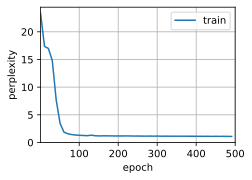

In [1]:
from d2l import torch as d2l
import torch
from torch import nn

# Load data
batch_size, num_steps, device = 32, 35, d2l.try_gpu()
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
# Define the model
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers, bidirectional=True)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
# Train the model
num_epochs, lr = 500, 1
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

The output is clearly unsatisfactory for the reasons described above. For a
discussion of more effective uses of bidirectional models, please see the sentiment
classification in :numref:`sec_sentiment_rnn`.

## Summary

* In bidirectional recurrent neural networks, the hidden state for each time step is simultaneously determined by the data prior to and after the current time step.
* Bidirectional RNNs bear a striking resemblance with the forward-backward algorithm in graphical models.
* Bidirectional RNNs are mostly useful for sequence embedding and the estimation of observations given bidirectional context.
* Bidirectional RNNs are very costly to train due to long gradient chains.

## Exercises

1. If the different directions use a different number of hidden units, how will the shape of $\mathbf{H}_t$ change?
1. Design a bidirectional recurrent neural network with multiple hidden layers.
1. Implement a sequence classification algorithm using bidirectional RNNs. Hint: use the RNN to embed each word and then aggregate (average) all embedded outputs before sending the output into an MLP for classification. For instance, if we have $(\mathbf{o}_1, \mathbf{o}_2, \mathbf{o}_3)$, we compute $\bar{\mathbf{o}} = \frac{1}{3} \sum_i \mathbf{o}_i$ first and then use the latter for sentiment classification.


[Discussions](https://discuss.d2l.ai/t/1059)
